# Q1

Acceptance Rate of mu: 0.26475
Acceptance Rate of sigma^2: 0.8286666666666667
Acceptance Rate of nu: 0.526
Effective sample size after burn-in and thinning: 2000


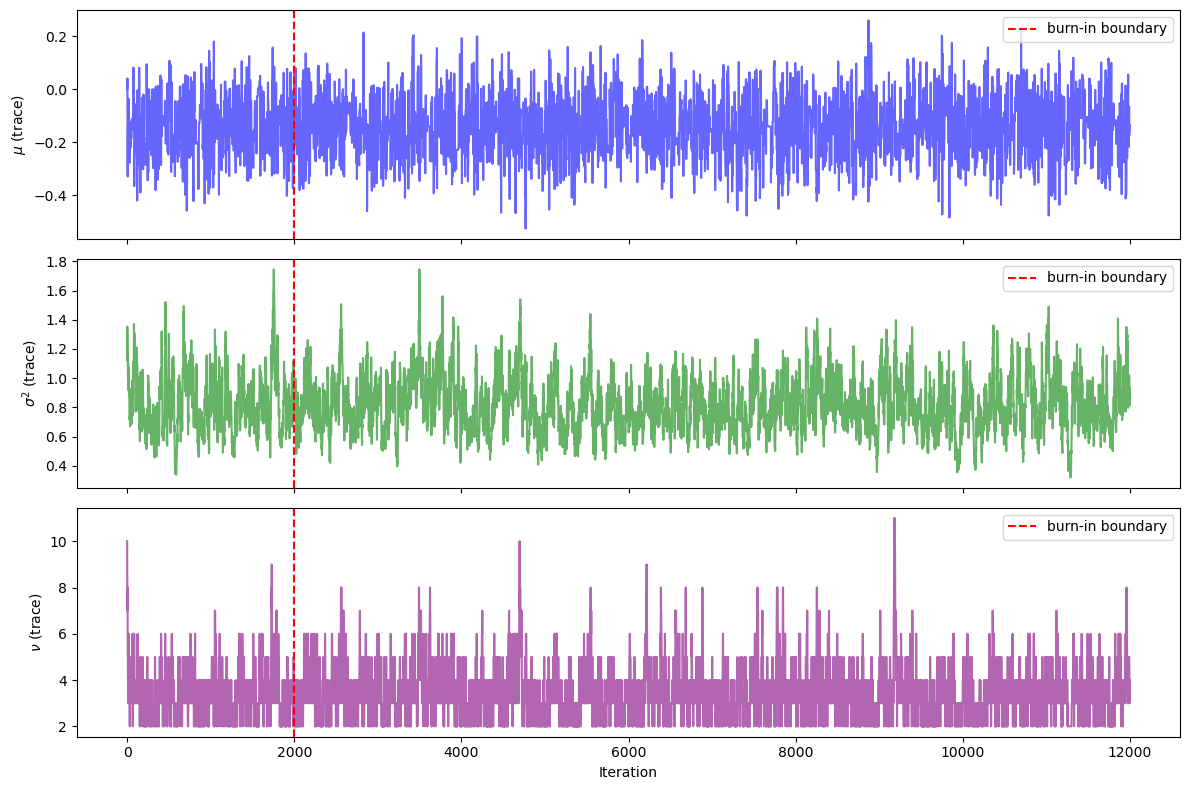

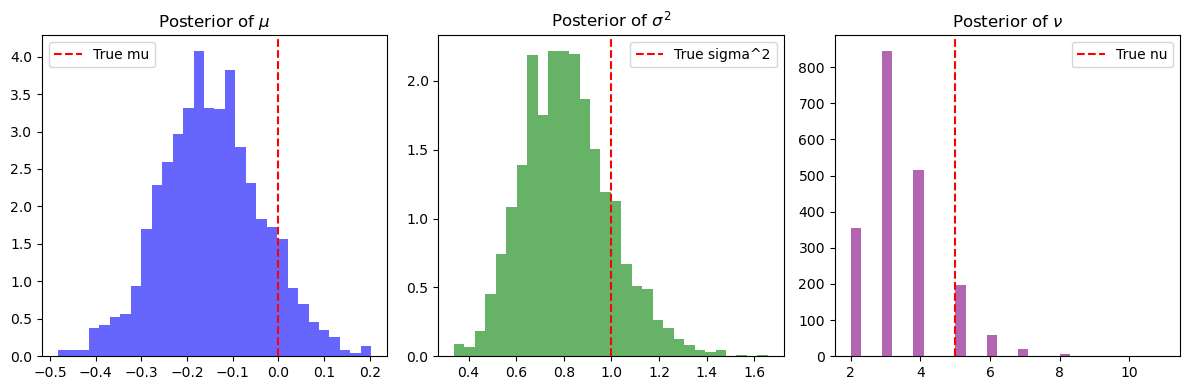

In [1]:
import numpy as np
import scipy.stats as stats
import matplotlib.pyplot as plt
from scipy.special import gammaln

# ------------------------------
# Parameter and Data Setup
# ------------------------------
np.random.seed(42)
n = 100
true_mu = 0.0
true_sigma2 = 1.0
true_nu = 5

# Generate sample
x = true_mu + np.sqrt(true_sigma2) * stats.t.rvs(df=true_nu, size=n)

# Prior hyperparameters
mu0 = 0.0
tau0 = 1.0
sigma0 = 1.0

# Demonstrating burn-in and thinning
burn_in = 2000
thin = 5

# ------------------------------
# Define log posterior function
# ------------------------------
def log_post(mu, sigma2, nu, x, mu0, tau0, sigma0):
    """
    Calculate the log-posterior for parameters (mu, sigma2, nu).
    Incorporates the Student's t likelihood, Normal(mu0, 1/tau0) prior (for mu),
    half-normal(sigma0^2) prior (for sigma^2), and discrete uniform prior (for nu).
    """
    # Check if sigma2 <= 0 or nu out of range
    if sigma2 <= 0 or nu < 1 or nu > 100:
        return -np.inf
    
    # 1) Student's t distribution log-likelihood
    #    f(x_i) = Gamma((nu+1)/2) / [Gamma(nu/2)*sqrt(pi*nu*sigma2)] * [1 + (x_i - mu)^2/(nu*sigma2)]^(-(nu+1)/2)
    #    We sum the log of that expression for each x_i
    ll = np.sum(gammaln((nu+1)/2)
                - gammaln(nu/2)
                - 0.5*np.log(np.pi*nu*sigma2)
                - ((nu+1)/2)*np.log(1 + ((x - mu)**2)/(nu*sigma2)))
    
    # 2) Prior for mu: Normal(mu0, 1/tau0)
    lp_mu = 0.5*np.log(tau0/(2*np.pi)) - (tau0/2) * (mu - mu0)**2
    
    # 3) Prior for sigma^2: half-normal(sigma0^2)
    #    half-normal ~ sqrt(2/(pi*sigma0^2)) * exp(-(sigma^2)^2 / (2*sigma0^2)), truncated at sigma^2>0
    lp_sigma2 = 0.5*np.log(2/(np.pi*sigma0**2)) - (sigma2**2)/(2*sigma0**2)
    
    # 4) Prior for nu: discrete uniform(1..100)
    #    p(nu) = 1/100 => log prior is -log(100)
    lp_nu = -np.log(100)
    
    return ll + lp_mu + lp_sigma2 + lp_nu

# ------------------------------
# MCMC (Metropolis within Gibbs) setup
# ------------------------------
iters = 12000  # total number of iterations

# Arrays to store samples
mu_samples = np.zeros(iters)
sigma2_samples = np.zeros(iters)
nu_samples = np.zeros(iters, dtype=int)

# Initial values
mu_current = 0.0
sigma2_current = 1.0
nu_current = 10

# Current log posterior
log_post_current = log_post(mu_current, sigma2_current, nu_current, x, mu0, tau0, sigma0)

# Proposal standard deviations
mu_prop_sd = 0.5
log_sigma2_prop_sd = 0.1

# Acceptance counters
acc_mu = 0
acc_sigma2 = 0
acc_nu = 0

# ------------------------------
# Metropolis within Gibbs Loop
# ------------------------------
for t in range(iters):
    # ---- 1) Update mu ----
    mu_proposal = mu_current + np.random.normal(0, mu_prop_sd)
    log_post_proposal = log_post(mu_proposal, sigma2_current, nu_current, x, mu0, tau0, sigma0)
    
    if np.log(np.random.rand()) < (log_post_proposal - log_post_current):
        mu_current = mu_proposal
        log_post_current = log_post_proposal
        acc_mu += 1
    
    mu_samples[t] = mu_current

    # ---- 2) Update sigma^2 ----
    # Use log scale random walk for sigma^2
    log_sigma2_current = np.log(sigma2_current)
    log_sigma2_proposal = log_sigma2_current + np.random.normal(0, log_sigma2_prop_sd)
    sigma2_proposal = np.exp(log_sigma2_proposal)
    
    # Jacobian term for the log-scale transformation
    log_post_proposal = log_post(mu_current, sigma2_proposal, nu_current, x, mu0, tau0, sigma0)
    mh_ratio = (log_post_proposal - log_post_current) + (log_sigma2_proposal - log_sigma2_current)
    
    if np.log(np.random.rand()) < mh_ratio:
        sigma2_current = sigma2_proposal
        log_post_current = log_post_proposal
        acc_sigma2 += 1
    
    sigma2_samples[t] = sigma2_current

    # ---- 3) Update nu ----
    # Propose nu with +/-1 move in [1..100]
    nu_proposal = nu_current + np.random.choice([-1, 1])
    nu_proposal = max(1, min(nu_proposal, 100))  # boundary check
    
    log_post_proposal = log_post(mu_current, sigma2_current, nu_proposal, x, mu0, tau0, sigma0)
    if np.log(np.random.rand()) < (log_post_proposal - log_post_current):
        nu_current = nu_proposal
        log_post_current = log_post_proposal
        acc_nu += 1
    
    nu_samples[t] = nu_current

# ------------------------------
# Calculate acceptance rates
# ------------------------------
acc_rate_mu = acc_mu / iters
acc_rate_sigma2 = acc_sigma2 / iters
acc_rate_nu = acc_nu / iters

print("Acceptance Rate of mu:", acc_rate_mu)
print("Acceptance Rate of sigma^2:", acc_rate_sigma2)
print("Acceptance Rate of nu:", acc_rate_nu)

# ------------------------------
# Discard burn-in and apply thinning
# ------------------------------
mu_samples_post = mu_samples[burn_in::thin]
sigma2_samples_post = sigma2_samples[burn_in::thin]
nu_samples_post = nu_samples[burn_in::thin]

print("Effective sample size after burn-in and thinning:", len(mu_samples_post))

# ------------------------------
# Visualization (Trace Plots)
# ------------------------------
fig, axs = plt.subplots(3, 1, figsize=(12, 8), sharex=True)
axs[0].plot(mu_samples, color='blue', alpha=0.6)
axs[0].set_ylabel("$\\mu$ (trace)")
axs[0].axvline(burn_in, color='r', linestyle='--', label='burn-in boundary')
axs[0].legend()

axs[1].plot(sigma2_samples, color='green', alpha=0.6)
axs[1].set_ylabel("$\\sigma^2$ (trace)")
axs[1].axvline(burn_in, color='r', linestyle='--', label='burn-in boundary')
axs[1].legend()

axs[2].plot(nu_samples, color='purple', alpha=0.6)
axs[2].set_ylabel("$\\nu$ (trace)")
axs[2].set_xlabel("Iteration")
axs[2].axvline(burn_in, color='r', linestyle='--', label='burn-in boundary')
axs[2].legend()

plt.tight_layout()
plt.show()

# ------------------------------
# Visualization (Histograms)
# ------------------------------
plt.figure(figsize=(12,4))
plt.subplot(1,3,1)
plt.hist(mu_samples_post, bins=30, color='blue', alpha=0.6, density=True)
plt.title("Posterior of $\\mu$")
plt.axvline(true_mu, color='red', linestyle='--', label='True mu')
plt.legend()

plt.subplot(1,3,2)
plt.hist(sigma2_samples_post, bins=30, color='green', alpha=0.6, density=True)
plt.title("Posterior of $\\sigma^2$")
plt.axvline(true_sigma2, color='red', linestyle='--', label='True sigma^2')
plt.legend()

plt.subplot(1,3,3)
plt.hist(nu_samples_post, bins=30, color='purple', alpha=0.6, density=False)
plt.title("Posterior of $\\nu$")
plt.axvline(true_nu, color='red', linestyle='--', label='True nu')
plt.legend()

plt.tight_layout()
plt.show()

# Q2

In [2]:
import numpy as np
import pymc as pm
import arviz as az
from scipy import stats

# Set random seed for reproducibility
np.random.seed(42)

# Different sample sizes to experiment with
sample_sizes = [50, 100, 500, 1000]

true_mu = 0.0
true_sigma = 1.0
true_nu = 5

results = {}

for n in sample_sizes:
    # Generate synthetic data from a Student's t distribution with known parameters
    x = true_mu + true_sigma * stats.t.rvs(df=true_nu, size=n)

    # Define the PyMC model
    with pm.Model() as model:
        # Prior for mu: Normal(0, 5)
        mu = pm.Normal("mu", mu=0, sigma=5)

        # Prior for sigma: HalfNormal(1)
        sigma = pm.HalfNormal("sigma", sigma=1)

        # Prior for nu: DiscreteUniform in [1, 100]
        nu = pm.DiscreteUniform("nu", lower=1, upper=100)

        # Likelihood: StudentT
        obs = pm.StudentT("obs", nu=nu, mu=mu, sigma=sigma, observed=x)

        # Draw samples
        # NUTS for mu, sigma; Metropolis for discrete nu
        idata = pm.sample(
            2000,       # number of posterior draws
            tune=1000,  # number of warm-up (burn-in) iterations
            chains=2,   # number of MCMC (Markov Chain Monte Carlo) chains
            target_accept=0.9,  # higher target_accept for more robust exploration
            return_inferencedata=True
        )

    results[n] = idata

# Summaries of posterior inferences for nu at each sample size
for n in sample_sizes:
    print(f"Sample size: {n}")
    summary_nu = az.summary(results[n], var_names=["nu"])
    print(summary_nu)
    print("-"*50)

Multiprocess sampling (2 chains in 4 jobs)
CompoundStep
>NUTS: [mu, sigma]
>Metropolis: [nu]


Sampling 2 chains for 1_000 tune and 2_000 draw iterations (2_000 + 4_000 draws total) took 2 seconds.
We recommend running at least 4 chains for robust computation of convergence diagnostics
Multiprocess sampling (2 chains in 4 jobs)
CompoundStep
>NUTS: [mu, sigma]
>Metropolis: [nu]


Sampling 2 chains for 1_000 tune and 2_000 draw iterations (2_000 + 4_000 draws total) took 3 seconds.
We recommend running at least 4 chains for robust computation of convergence diagnostics
Multiprocess sampling (2 chains in 4 jobs)
CompoundStep
>NUTS: [mu, sigma]
>Metropolis: [nu]


Sampling 2 chains for 1_000 tune and 2_000 draw iterations (2_000 + 4_000 draws total) took 3 seconds.
We recommend running at least 4 chains for robust computation of convergence diagnostics
Multiprocess sampling (2 chains in 4 jobs)
CompoundStep
>NUTS: [mu, sigma]
>Metropolis: [nu]


Sampling 2 chains for 1_000 tune and 2_000 draw iterations (2_000 + 4_000 draws total) took 3 seconds.
We recommend running at least 4 chains for robust computation of convergence diagnostics


Sample size: 50
      mean      sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  ess_tail  \
nu  54.513  27.106     9.0     97.0      1.024    0.724     693.0     759.0   

    r_hat  
nu    1.0  
--------------------------------------------------
Sample size: 100
     mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  ess_tail  \
nu  2.112  0.574     1.0      3.0      0.037    0.026     220.0     170.0   

    r_hat  
nu   1.01  
--------------------------------------------------
Sample size: 500
     mean    sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  ess_tail  \
nu  7.713  3.62     4.0     13.0      0.245    0.173     231.0     203.0   

    r_hat  
nu   1.01  
--------------------------------------------------
Sample size: 1000
     mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  ess_tail  \
nu  7.438  1.771     5.0     11.0      0.097     0.07     358.0     509.0   

    r_hat  
nu   1.01  
--------------------------------------------------


# Q3

1. **Background and Objective**  
       The core of this question is to multiply the normal distribution (normal distribution) likelihood $ p(y_i \mid \tau_i) $ by the gamma distribution (gamma distribution) prior $ p(\tau_i) $ and then integrate out $\tau_i$. The result is a Student’s t distribution, illustrating why marginalizing over variance (or precision) uncertainty in a hierarchical model leads to heavier tails.

    2. **Step 1: Setting Up the Integral with the Kernel**  
       Assume:
       $
         p(\tau_i) = \text{Gamma}\!\Bigl(\tau_i \;\Big|\; \alpha = \tfrac{\nu}{2},\, \beta = \tfrac{\nu}{2}\Bigr),
         \quad
         p(y_i \mid \tau_i) = \mathcal{N}\bigl(y_i \mid 0,\, \tau_i\bigr).
       $
       Here, $\tau_i$ is treated as the variance of the normal distribution.  
       Thus,
       $
         p(y_i \mid \tau_i)
         = \sqrt{\frac{\tau_i}{2\pi}} \,\exp\Bigl(-\tfrac{1}{2}\,\tau_i\,y_i^2\Bigr).
       $
       The prior is:
       $
         p(\tau_i)
         = \frac{\bigl(\tfrac{\nu}{2}\bigr)^{\tfrac{\nu}{2}}}{\Gamma\bigl(\tfrac{\nu}{2}\bigr)}\,\tau_i^{\tfrac{\nu}{2}-1}\,\exp\!\Bigl(-\tfrac{\nu}{2}\,\tau_i\Bigr), 
         \quad \tau_i>0.
       $
       We multiply and integrate over $\tau_i$ from 0 to $\infty$:
       $
         \int_{0}^{\infty} p(y_i \mid \tau_i)\,p(\tau_i)\,\mathrm{d}\tau_i 
         \;=\;
         \int_{0}^{\infty}
           \sqrt{\frac{\tau_i}{2\pi}} 
           \exp\!\Bigl(-\tfrac{1}{2}\,\tau_i\,y_i^2\Bigr)\,\,
           \frac{\bigl(\tfrac{\nu}{2}\bigr)^{\tfrac{\nu}{2}}}{\Gamma\bigl(\tfrac{\nu}{2}\bigr)}
           \,\tau_i^{\tfrac{\nu}{2}-1}\,\exp\!\Bigl(-\tfrac{\nu}{2}\,\tau_i\Bigr)
           \,\mathrm{d}\tau_i.
       $

    3. **Step 2: Combining the Exponential and Power Terms**  
       Merge the powers of $\tau_i$:
       $
         \tau_i^{\tfrac{1}{2}} \times \tau_i^{\tfrac{\nu}{2}-1}
         = \tau_i^{\bigl(\tfrac{1}{2} + \tfrac{\nu}{2} - 1\bigr)}
         = \tau_i^{\tfrac{\nu-1}{2}}.
       $
       Combine the exponentials:
       $
         \exp\!\Bigl(-\tfrac{1}{2}\,\tau_i\,y_i^2\Bigr)\,\exp\!\Bigl(-\tfrac{\nu}{2}\,\tau_i\Bigr)
         = \exp\!\Bigl(-\tfrac{1}{2}\,\tau_i\,(y_i^2 + \nu)\Bigr).
       $
       Hence, the integrand can be factored as:
       $
         \sqrt{\frac{\bigl(\tfrac{\nu}{2}\bigr)^{\tfrac{\nu}{2}}}{2\pi\,\Gamma\bigl(\tfrac{\nu}{2}\bigr)}} 
         \;\;\tau_i^{\tfrac{\nu-1}{2}}
         \;\;\exp\!\Bigl(-\tfrac{1}{2}\,\tau_i\,(y_i^2 + \nu)\Bigr).
       $
       Ignoring the constants that do not depend on $\tau_i$, we recognize a gamma kernel (kernel of a gamma distribution). Its shape parameter (sometimes denoted $a$) and rate parameter (sometimes denoted $b$) become:
       $
         a = \frac{\nu-1}{2} + 1 
         = \frac{\nu+1}{2}, 
         \quad
         b = \frac{y_i^2 + \nu}{2}.
       $

    4. **Step 3: Identifying the Gamma Kernel and Integrating**  
       For a gamma distribution with shape $a$ and rate $b$, the integral over $\tau_i$ from 0 to $\infty$ of its kernel is
       $
         \int_{0}^{\infty} \tau_i^{\,a -1} \exp(-b\,\tau_i)\,\mathrm{d}\tau_i
         = \frac{\Gamma(a)}{b^a}.
       $
       Substituting $a = \tfrac{\nu+1}{2}$ and $b = \tfrac{y_i^2 + \nu}{2}$, we get a constant term that remains after the integral.

    5. **Step 4: Simplifying to Obtain the Student’s t Distribution**  
       After simplification, the expression for $y_i$ reduces to:
       $
         \int_{0}^{\infty} p(y_i\mid \tau_i)\,p(\tau_i)\,\mathrm{d}\tau_i
         \;=\;
         \frac{\Gamma\bigl(\tfrac{\nu+1}{2}\bigr)}{\sqrt{\pi\,\nu}\,\Gamma\bigl(\tfrac{\nu}{2}\bigr)} 
         \Bigl(1 + \frac{y_i^2}{\nu}\Bigr)^{-\tfrac{\nu+1}{2}},
       $
       which is precisely the probability density function $ \text{pdf} $ (probability density function) of a Student’s t distribution with degrees of freedom (df) $\nu$, location 0, and scale 1:
       $
         y_i \sim t_{\nu}(0,\,1).
       $

    6. **Significance and Conclusion**  
       - **Heavier Tails**: Integrating out the variance (or precision) $\tau_i$ transforms what would be a normal distribution into a Student’s t distribution with heavier tails.  
       - **Posterior Predictive Distribution**: In a Bayesian setting, a normal likelihood with a gamma prior on the variance typically yields a t distribution for the predictive or marginal distribution. This reflects additional uncertainty in the variance, manifested as heavier tails, providing better robustness to outliers (outliers) than a plain normal distribution.